In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Creating neural network from scratch in Python

We generate a classification dataset that is not easily linearly separable. We produce a spiral datset, which can be generated as follows

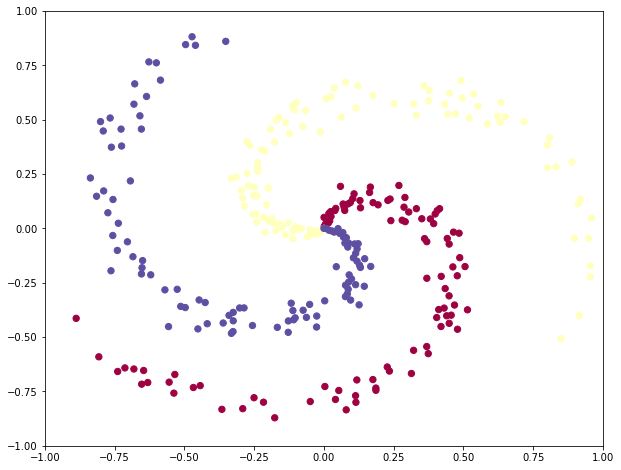

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()
#fig.savefig('spiral_raw.png')

The toy spiral data consists of three classes (blue, red, yellow) that are not linearly separable. Usually, we would need to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step.

## Case 1: Training with a Linear Classifier

In [3]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
# D=2 is the dimesionality and K=3 is the number of classes
b = np.zeros((1,K))

This computation is for a linear classifier, therefore we can compute all class scores very simply in parallel with a single matrix multiplication:

We have 300 2D points, so after the multiplication, the array **scores** will have size [300 x 3], where each row gives the class scores corresponding to the 3 classes (blue, red, yellow).

Things to know about Loss Function:
 
1. We want the correct class to have a higher score than the other classes. When this is the case, the loss should be low and otherwise the loss should be high.

2. We will use the softmax classifier here for multiclass classification, with which we can convert the entry in vector **scores** with the respective probabilities.

3. When the correct class probability goes towards 1, the loss will go towards zero because log(1)=0. Hence, the expression for $L_i$ is low when the correct class probability is high, and it’s very high when it is low.

$L_i = -\log \left(\frac{\exp^{f_{y_i}}}{\sum_j \exp^{f_{j}}}\right)$

The array **correct_logprobs** is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

$L =\frac{1}{N} \sum_{i} L_i +\frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2$, 

The first term is the data loss and the second term is the regularization loss

In [4]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
 # evaluate class scores, [N x K], will have size [300 * 3]
    scores = np.dot(X, W) + b 

## Given the array of Scores we have computed above, we next compute the loss. 
## We compute the probabilities using the softmax function.    
# We compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  # We now have an array probs of size [300 x 3], where each row now 
  # contains the class probabilities. In particular, since we’ve normalized 
  # them every row now sums to one. 
  # We can now query for the log probabilities assigned to the 
  # correct classes in each example  
    corect_logprobs = -np.log(probs[range(num_examples),y])
#he array correct_logprobs is a 1D array of just the probabilities 
#assigned to the correct classes for each example

# compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print("iteration %d: loss %f" % (i, loss))
  
 # compute the gradient on scores with Backpropagation
# probs stores the probabilities of all classes (as rows) for each example.
# To get the gradient on the scores, we proceed as follows with dscores:
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
  
    dW += reg*W # regularization gradient
  
  # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.096919
iteration 10: loss 0.917310
iteration 20: loss 0.851535
iteration 30: loss 0.822352
iteration 40: loss 0.807594
iteration 50: loss 0.799452
iteration 60: loss 0.794683
iteration 70: loss 0.791765
iteration 80: loss 0.789921
iteration 90: loss 0.788726
iteration 100: loss 0.787937
iteration 110: loss 0.787408
iteration 120: loss 0.787049
iteration 130: loss 0.786803
iteration 140: loss 0.786633
iteration 150: loss 0.786514
iteration 160: loss 0.786431
iteration 170: loss 0.786373
iteration 180: loss 0.786331
iteration 190: loss 0.786302


Let us consider the loss for one example:

$p_k = \frac{\exp^{f_k}}{\sum_j \exp^{f_j}}, \quad L_i = -\log(p_{y_i})$

$\frac{\partial L_i}{\partial f_k} = p_k - 1 (y_i = k )$

Say p = [0.2,0.3,0.5], say the correct class is 1, then df = [0.2,-0.7,0.5]

In [5]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.49


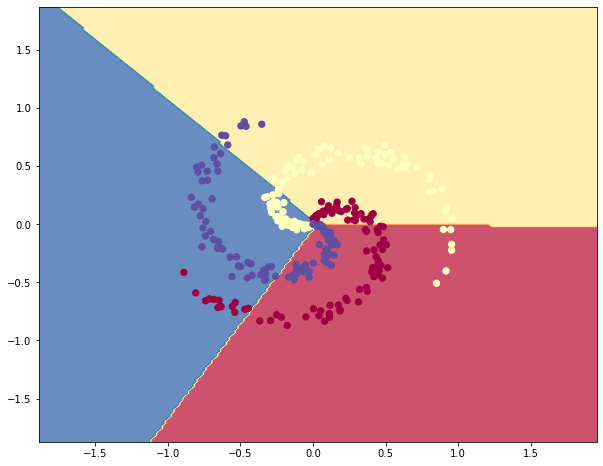

In [6]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()
#fig.savefig('spiral_linear.png')

## Linear classifier as we see fails to learn the toy spiral dataset

## Case 2: Training with a Neural Network

A linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data

In [7]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
# Notice that the only change from before is one extra line of code, 
# where we first compute the hidden layer representation and then 
# the scores based on this hidden layer. Crucially, we’ve also added a non-linearity, 
# which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

  # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
  # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

  # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

  # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.098637
iteration 1000: loss 0.294416
iteration 2000: loss 0.266441
iteration 3000: loss 0.251507
iteration 4000: loss 0.248295
iteration 5000: loss 0.247107
iteration 6000: loss 0.246421
iteration 7000: loss 0.245961
iteration 8000: loss 0.245331
iteration 9000: loss 0.245060


In [8]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


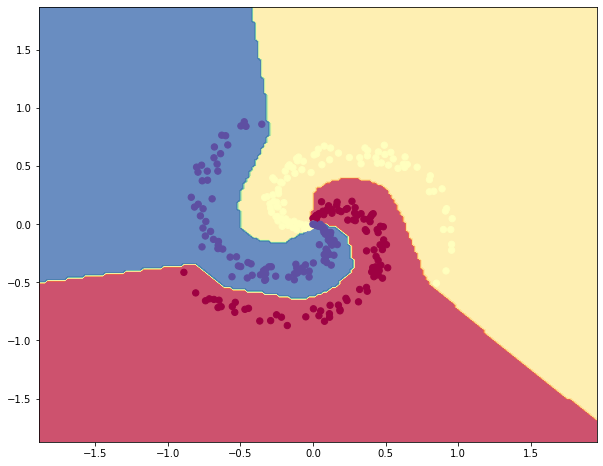

In [9]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()
#fig.savefig('spiral_net.png')

## Example 2: Building a neural netork from  scratch for the heart dataset

In [15]:
#Importing the dataset 

import csv
import pandas as pd

# add header names
headers =  ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']

heart_df = pd.read_csv('heart.dat', sep=' ', names=headers)
heart_df.head()

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [16]:
#Getting shape of the data
heart_df.shape

(270, 14)

In [17]:
#Looking for the null values through the dataset because neural net require non null variables
heart_df.isna().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate_achieved    0
exercise_induced_angina    0
oldpeak                    0
slope of the peak          0
num_of_major_vessels       0
thal                       0
heart_disease              0
dtype: int64

In [18]:
#Splitting the dataset into training and test parts
import numpy as np
import warnings
warnings.filterwarnings("ignore") #suppress warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#convert input to numpy arrays
X = heart_df.drop(columns=['heart_disease'])

#replace target class with 0 and 1 
#1 means "have heart disease" and 0 means "do not have heart disease"
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1, 0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2, 1)

y_label = heart_df['heart_disease'].values.reshape(X.shape[0], 1)

#split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


The forward propagation in our neural network is defined as:

1. $Z_1 = X. W_1 + b_1$
2. $A_1$ = ReLU $(Z_1)$
3. $Z_2 = A_1 .W_2 + b_2$
4. $\hat{y} = \frac{1}{1+ \exp^{-Z_2}}$

The loss function in our case will try to compute how far our predicted output is from the true output

Loss (L) = $-y \log \hat{y} - (1-y) \log (1-\hat{y})$

$\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y} }{\partial Z_2} \frac{\partial Z_2}{\partial W_2}$

$\frac{\partial L}{\partial W_1} =  \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial Z_2} \frac{\partial Z_2}{\partial A_1}\frac{\partial A_1}{\partial Z_1}\frac{\partial Z_1}{\partial W_1}$

We next compute the derivates:

$\frac{\partial L}{\partial \hat{y}} = -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}, \frac{\partial \hat{y} }{\partial Z_2} = \hat{y} (1-\hat{y}),  \frac{\partial Z_2}{\partial W_2} = A_1, \frac{\partial Z_2}{\partial A_1} = W_2, \quad \frac{\partial Z_1}{\partial W_1} = X, \frac{\partial A_1}{\partial Z_1} = 0$ for $Z_1 \leq 0$, 1 for $Z_1 > 0$

The Loss function with respect to the bias terms are given as:

$\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y} }{\partial Z_2} \frac{\partial Z_2}{\partial b_2} = \hat{y} (1-\hat{y})\left( -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\right)$

$\frac{\partial L}{\partial b_1} =  \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial Z_2} \frac{\partial Z_2}{\partial A_1}\frac{\partial A_1}{\partial Z_1}\frac{\partial Z_1}{\partial b_1} = \frac{\partial A_1}{\partial Z_1}\cdot W_2 \cdot \hat{y} (1-\hat{y})\cdot \left( -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\right) $

In [19]:
#Implementing Neural network class

class NeuralNet():
    '''
    A two layer neural network
    '''
    
        
    def __init__(self):
        self.params = {}
        self.learning_rate = 0.001
        self.iterations = 100
        self.loss = []
        self.sample_size = None
        self.layers = [13,8,1]
        self.X = None
        self.y = None    
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        
    def relu(self,Z):
        '''
        The ReLu activation function is to performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0,Z)
    
    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1.0/(1.0+np.exp(-Z))
    
    def entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((1 - y), np.log(1 - yhat))))
        return loss
    
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss
    
    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        dl_wrt_yhat = -(np.divide(self.y,yhat) - np.divide((1 - self.y),(1-yhat)))
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)
        
        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2
        
    
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred) 
        
    
    def acc(self, y, yhat):
        '''
        Calculates the accuracy between the predicted values and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

In [20]:
nn = NeuralNet() # create the NN model
nn.fit(Xtrain, ytrain) #train the model

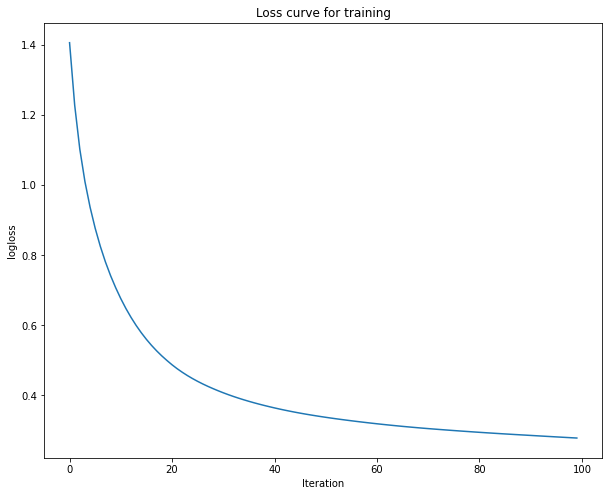

In [21]:
nn.plot_loss()

In [22]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print("Train accuracy is {}".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.acc(ytest, test_pred)))

Train accuracy is 87
Test accuracy is 75


In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest,test_pred)
print(cm)

[[26  6]
 [ 7 15]]


###  **Change iterations to 300 and learning rate to 0.01, 0.0001 and calculate plot_loss() as well as accuracy**

Keras is a powerful and easy-to-use free open source Python library for developing and evaluating deep learning models.

It wraps the efficient numerical computation libraries Theano and TensorFlow and allows you to define and train neural network models in just a few lines of code

Models in Keras are defined as a sequence of layers.

We create a Sequential model and add layers one at a time until we are happy with our network architecture.

The first thing to get right is to ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument and setting it to 8 for the 8 input variables.

How do we know the number of layers and their types?

This is a very hard question. There are heuristics that we can use and often the best network structure is found through a process of trial and error experimentation (I explain more about this here). Generally, you need a network large enough to capture the structure of the problem.

Fully connected layers are defined using the Dense class. We can specify the number of neurons or nodes in the layer as the first argument, and specify the activation function using the activation argument.

We will use the rectified linear unit activation function referred to as ReLU on the first layer and the Sigmoid function in the output layer.

It used to be the case that Sigmoid and Tanh activation functions were preferred for all layers. These days, better performance is achieved using the ReLU activation function. We use a sigmoid on the output layer to ensure our network output is between 0 and 1 and easy to map to either a probability of class 1 or snap to a hard classification of either class with a default threshold of 0.5.

In [25]:
#With Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# define the model
model = Sequential()
model.add(Dense(8, input_shape=(13,), activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Note, the most confusing thing here is that the shape of the input to the model is defined as an argument on the first hidden layer. This means that the line of code that adds the first Dense layer is doing 2 things, defining the input or visible layer and the first hidden layer.

## Compiling Keras model

Compiling the model uses the efficient numerical libraries under the covers (the so-called backend) such as Theano or TensorFlow. The backend automatically chooses the best way to represent the network for training and making predictions to run on your hardware, such as CPU or GPU or even distributed.

When compiling, we must specify some additional properties required when training the network. Remember training a network means finding the best set of weights to map inputs to outputs in our dataset.

We must specify the loss function to use to evaluate a set of weights, the optimizer is used to search through different weights for the network and any optional metrics we would like to collect and report during training.

In this case, we will use cross entropy as the loss argument. This loss is for a binary classification problems and is defined in Keras as “binary_crossentropy“

We will define the optimizer as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.

In [26]:
# compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

### Fit Keras model

We can train or fit our model on our loaded data by calling the fit() function on the model.

Training occurs over epochs and each epoch is split into batches.

Epoch: One pass through all of the rows in the training dataset.
Batch: One or more samples considered by the model within an epoch before weights are updated.

In [27]:
model.fit(Xtrain, ytrain, epochs=100, verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 0.6877 - accuracy: 0.6250
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 0.6678 - accuracy: 0.6481
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6713
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6301 - accuracy: 0.6852
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6137 - accuracy: 0.6991
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 0.5984 - accuracy: 0.7037
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 0.5834 - accuracy: 0.7130
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.7176
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7315
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5433 - accuracy: 0.7407
Epoch 11/100
7/7 [===========

7/7 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.8796
Epoch 85/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8796
Epoch 86/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8796
Epoch 87/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2792 - accuracy: 0.8796
Epoch 88/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.8796
Epoch 89/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2772 - accuracy: 0.8796
Epoch 90/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.8796
Epoch 91/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2751 - accuracy: 0.8796
Epoch 92/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2744 - accuracy: 0.8796
Epoch 93/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2732 - accuracy: 0.8796
Epoch 94/100
7/7 [===============

### Evaluate the model

You can evaluate your model on your training dataset using the evaluate() function on your model and pass it the same input and output used to train the model.

This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.

The evaluate() function will return a list with two values. The first will be the loss of the model on the dataset and the second will be the accuracy of the model on the dataset. We are only interested in reporting the accuracy, so we will ignore the loss value.

In [30]:
train_acc = model.evaluate(Xtrain, ytrain, verbose=1)[1]
# print(train_acc)
test_acc = model.evaluate(Xtest, ytest, verbose=1)[1]
# print(test_acc)
print("Train accuracy of keras neural network: {}".format(round((train_acc * 100), 2)))
print("Test accuracy of keras neural network: {}".format(round((test_acc * 100),2)))

2/2 [==============================] - 0s 2ms/step - loss: 0.5649 - accuracy: 0.7407
Train accuracy of keras neural network: 88.43
Test accuracy of keras neural network: 74.07


### Making Predictions

Making predictions is as easy as calling the predict() function on the model. We are using a sigmoid activation function on the output layer, so the predictions will be a probability in the range between 0 and 1. We can easily convert them into a crisp binary prediction for this classification task by rounding them.

In [33]:
# make probability predictions with the model
predictions = model.predict(Xtest)
print(predictions[:5])

2/2 [==============================] - 0s 2ms/step
[[0.558064  ]
 [0.16077903]
 [0.5860038 ]
 [0.9902646 ]
 [0.1366327 ]]


In [34]:
# round predictions 
y_pred = [round(x[0]) for x in predictions]
print(y_pred)

[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [36]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        32
           1       0.68      0.68      0.68        22

    accuracy                           0.74        54
   macro avg       0.73      0.73      0.73        54
weighted avg       0.74      0.74      0.74        54



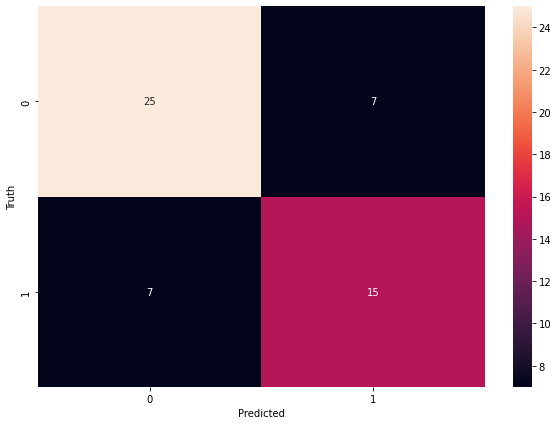

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt
cm = confusion_matrix(ytest,y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
#How to save Keras models
#save model and architecture to single file
model.save("model_9.h5")
print("Saved model to disk")

In [ ]:
#How to load saved keras model and use it again
from numpy import loadtxt
from tensorflow.keras.models import load_model
 
# load model
model = load_model("model_9.h5")
# summarize model.
model.summary()

In [ ]:
model.predict(Xtest)